### Luminosity computation

In this [notebook](https://gitlab.cern.ch/sterbini/lhcmaskdoc/-/blob/master/docs/ipynbs/luminosity_formula/luminosity_formula.ipynb),  we implement a python function to compute the luminosity for Gaussian beams.


The aim is to have a quite general formula of the luminosity to be used in MAD-X for the luminosity leveling module. Indeed the luminosity leveling is based on an (numerical) inversion of the luminosity formula. To invert the function in a reasonable time we will make some assumptions but we need to maintain some intrinsic aspect (crossing angle, hourglass effect, crab cavities, offsets, flat-optics...) characteristic that could be addressed from MAD-X leveling.

The function will take into account B1/B2 differences in the H/V emittances, optics, orbit, dispersions, crossing angle and separation in the two planes. The crab cavities (CC) tilt is also considered (crossing and kissing tilt). 

The approach we followed is the one presented in [1, [M. Sypher, 2007](https://home.fnal.gov/~syphers/Accelerators/tevPapers/LumiCalc.pdf)]
that is complementary to the one of [2, [W. Herr and B. Muratori, 2006](https://cds.cern.ch/record/941318)]. Very interesting is also the crab-kissing paper [3, [S. Fartoukh, 2014](https://journals.aps.org/prab/pdf/10.1103/PhysRevSTAB.17.111001)].

The luminosity is 

\begin{equation}
L=N_1 N_2 n_b f_r \underbrace{\sqrt{(\vec{v_1}-\vec{v_2})^2-\frac{(\vec{v_1} \times \vec{v_2})^2}{c^2}}}_{Moeller factor}
\int_{-\infty}^{\infty}
\int_{-\infty}^{\infty}
\int_{-\infty}^{\infty}
\int_{-\infty}^{\infty}  \rho^{B1} \rho^{B2} ~~ dx dy dz dt 
\end{equation}

with the following **normalization condition**

\begin{equation}
\int_{-\infty}^{\infty}
\int_{-\infty}^{\infty}
\int_{-\infty}^{\infty}
\int_{-\infty}^{\infty} \rho^{B} dx dy dz dt =1,\quad {\rm with }~B\in\{B1,B2\}
\end{equation}.

The $\rho$ represents the beam distribution, $N$ the number of particle per bunch, $\vec{v}$ the velocity vector, $n_b$ the number of collision at the Interaction Point (IP), $f_{rev}$ the frequency of the collisions, $c$ the amplitude of the speed of the light.   

!!! info
    Note that $n_b$, $f_{rev}$ and $c$ are not beam dependent properties. All the rest are beam dependent and denoted with the $1$,$2$ or B1/B2 sub/superscripts.


The {x,y,z} is the geometrical frame common to the two beams. The origin corresponds to the nominal IP.

The proposed python implementation considers the following working hypotheses (HP).

#### HP0: Moeller factor as constant

We assume that, in the Moeller factor [4, [M. A. Furman, 2003](https://www.osti.gov/servlets/purl/836235)], $\vec{v_1}$ and $\vec{v_2}$ are independent from $x,~y,~z$ and $t$.

In ultra-relativistic regime $\vec{v_1}=-\vec{v_2}$ and  $|\vec{v_1}|=|\vec{v_2}|=c$, then the Moeller factor is $2 c$.

#### HP1: factorization of distributions

\begin{equation}
\rho^{B}=\prod_{i\in\{x,y,z\}} \rho_i^B,\quad {\rm with }~B\in\{B1,B2\}
\end{equation}

This implies that the distribution in $x$,$y$ and $z$ are not correlated.

!!! warning
    For HP1, we cannot consider distribution tilted in the X-Y plane (e.g., due to coupling).

#### HP2:  transverse dependence wrt z
\begin{eqnarray}
\rho_x^{B}&=&\rho_x^{B}(x,z,t),\quad &{\rm with }~B\in\{B1,B2\} \\
\rho_y^{B}&=&\rho_y^{B}(y,z,t),\quad &{\rm with }~B\in\{B1,B2\} \\
\rho_z^{B}&=&\rho_z^{B}(z,t),\quad &{\rm with }~B\in\{B1,B2\} \\
\end{eqnarray}

This follows from the paraxial approximation (please note that this is explicitly mentioned in [1,3]. In [2] this HP is relaxed at the start of the analysis (e.g., considering that $\rho_z^{B}=\rho_z^{B}(z,x,t)$ (crossing angle in the x-plane) but, de facto, the linear approximation performed afterwards is equivalent to a paraxial approximation)).

!!! info
    Note that the transverse distributions do depend on the longitudinal coordinate ($z$) but the longitudinal distribution does NOT depend on the transverse coordinate ($x$ and $y$).

#### HP3: normal distribution
\begin{equation}
\rho_i^B=\frac{1}{\sqrt{2\pi}\sigma_{i,B}} e^{-\frac{(i-\mu_{i,B})^2}{2\sigma_{i,B}^2}},\quad {\rm with }~B\in\{B1,B2\}~{\rm and}~i\in\{x,y,z\}
\end{equation}

The HP3 can be relaxed, as we will see.

The main idea is to reduce the 4-integral in x,y,z,t into 2-integral in z and t by solving the integral in x and y analytically. This is possible since, in our case, $\rho_z$ does not depend on x and y (whereas $\rho_{x,y}$ does depend on $z$ and $t$). The key point is to observe that the $\rho_x$ and $\rho_y$ distributions are conditioned to the $z$-variable and the $t$ parameter (that is the $\mu_{x,y}=\mu_{x,y}(z, z\pm ct)$ and $\sigma_{x,y}=\sigma_{x,y}(z)$, see HP2). Therefore we have

\begin{equation}
L=N_1 N_2 n_b f_r \underbrace{\sqrt{(\vec{v_1}-\vec{v_2})^2-\frac{(\vec{v_1} \times \vec{v_2})^2}{c^2}}}_{Moeller~factor}
\int_{-\infty}^{\infty}
\int_{-\infty}^{\infty}
\rho_z^{B1} \rho_z^{B2}~ 
\underbrace{\int_{-\infty}^{\infty} \rho_x^{B1} \rho_x^{B2} dx}_{to~solve~analytically}~
\underbrace{\int_{-\infty}^{\infty} \rho_y^{B1} \rho_y^{B2}dy}_{to~solve~analytically}~
dz dt 
\end{equation}

After the partial integration,  the speed of the numerical computation is **greatly improved and this opens the possibility to invert numerically the function and solving the leveling problem in a general way**.

In fact this is our main goal: have a fast and general implementation of the luminosity computation to be used for the leveling in MAD-X.


The problem to compute L therefore reduces
1. in integrating (analytically) the general Gaussian expression of the luminosity in $x$ and $y$.
2. in expressing the parameters $\mu_{x,y}$ and $\sigma_{x,y}$ as function of $z$ and $t$.
3. in integrating (numerically) in $z$ and $t$.

If CC are not present, then we can consider also the analytical integration in the $t$-domain: in this specific case the problem therefore reduces

1. in integrating the general Gaussian expression of the luminosity in $x$, $y$ and $t$.
2. in expressing the parameters $\mu_{x,y}$ and $\sigma_{x,y}$ as function of $z$.
3. in integrating (numerically) in $z$.

For convenience, we express, in the followings, the different quantities using MAD-X conventions and units.

In [2]:
import numpy as np
from cl2pd import particle
from scipy import integrate
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import sympy as sym

In [3]:
x, y, z, t, mux1, muy1, muz1, mux2, muy2, muz2 = sym.symbols('x y z t \mu_{x1} \mu_{y1} \mu_{z1} \mu_{x2} \mu_{y2} \mu_{z2}', real=True)
sigmax1, sigmay1, sigmaz1, beta1,\
sigmax2, sigmay2, sigmaz2, beta2,\
c, N1, N2, f, nb = sym.symbols('''
\sigma_{x1} \sigma_{y1} \sigma_{z1} \\beta_{r1}
\sigma_{x2} \sigma_{y2} \sigma_{z2} \\beta_{r2}
c N_1 N_2 f_{r} n_{b}''', positive=True)

def rho(x, mux, sigmax):
    return 1/sym.sqrt(2*sym.pi)/sigmax * sym.exp(-(x-mux)**2/2/sigmax**2)

#### Sanity check on the normalization
The integral has to be one (Condition 0).

In [4]:
sym.integrate(rho(x, mux1, sigmax1)*rho(y, muy1, sigmay1)*rho(z, muz1, sigmaz1), (x, -sym.oo , sym.oo),(y, -sym.oo , sym.oo),(z, -sym.oo , sym.oo))

1

### Analytical integration
#### x-integration

In [5]:
x_factor=sym.integrate(rho(x, mux1, sigmax1)*rho(x, mux2, sigmax2), (x, -sym.oo , sym.oo))
x_factor=x_factor.factor().simplify().simplify()
x_factor

sqrt(2)*exp((-\mu_{x1}**2/2 + \mu_{x1}*\mu_{x2} - \mu_{x2}**2/2)/(\sigma_{x1}**2 + \sigma_{x2}**2))/(2*sqrt(pi)*sqrt(\sigma_{x1}**2 + \sigma_{x2}**2))

#### What if the $\rho_x$ is not Gaussian?
We will compare the previous integral with a uniform distributions.
To do that we assume centered distribution with rms equal to 1 (normalized rms).

In [6]:
# centered uniform distribution parametric wrt sigma
def rho_uniform(x, sigma):
    a=np.sqrt(3)*sigma
    if x>a or x<-a:
        return 0
    else:
        return 1/2/a

# Sanity check: integral shuld be one   
print(integrate.quad(lambda z: rho_uniform(z,1), -2, 2))

# Sanity check: rms shuld be one   
print(integrate.quad(lambda z: rho_uniform(z,1)*(z**2), -2, 2))


(0.9999999992599697, 2.5811401825156003e-08)
(0.9999999977799099, 7.743418181927893e-08)


/usr/local/bin/start_ipykernel.py:10: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/usr/local/bin/start_ipykernel.py:13: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


In [7]:
# Integral
a=integrate.quad(lambda z: rho_uniform(z,1)**2, -2, 2)
print('Integration...')
print(a)

Integration...
(0.28867513346922036, 1.1765582563771915e-08)


To compare the above integral with the Gaussian integral we need to decide the equivalence criterion between a Gaussian and uniform distribution. I see two possibilities:
1. Gaussian fit of the uniform distribution
2. Gaussian with the same RMS size of the uniform distribution 

We will see that the second approach is "more equivalent" in terms of luminosity, even if, the operational definition for  measured distributions in the machine tends to follow the first approach.

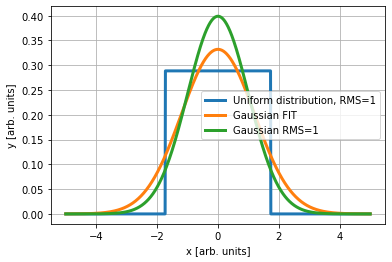

In [8]:
from scipy.optimize import curve_fit
def gauss(x,sigma):
    return 1/np.sqrt(2*np.pi)/sigma*np.exp(-(x)**2/2/sigma**2)

x=np.linspace(-5,5,1000)
yy=[]

for i in x:
    yy.append(rho_uniform(i, 1))

plt.plot(x,yy, lw=3, label = 'Uniform distribution, RMS=1')
popt,pcov = curve_fit(gauss,x,yy,p0=[1])
plt.plot(x,gauss(x,popt), lw=3, label='Gaussian FIT')
plt.plot(x,gauss(x,1), lw=3, label='Gaussian RMS=1')
plt.legend(loc='best')
plt.xlabel('x [arb. units]')
plt.ylabel('y [arb. units]')
plt.grid(True)

In [9]:
print('#########################################################################################')
print('Relative error of the integral (only 1-dimension) with respect to the Gaussian FIT:')
print(f'{(a[0]/sym.N(x_factor.subs([(sigmax1,popt),(sigmax2,popt),(mux1,0),(mux2,0)]))-1)*100}%')

print('#########################################################################################')
print('Relative error of the integral (only 1-dimension) with respect to the Gaussian with the same RMS:')
print(f'{((a[0]/sym.N(x_factor.subs([(sigmax1,1),(sigmax2,1),(mux1,0),(mux2,0)])))-1)*100}%')

#########################################################################################
Relative error of the integral (only 1-dimension) with respect to the Gaussian FIT:
22.9012491917252%
#########################################################################################
Relative error of the integral (only 1-dimension) with respect to the Gaussian with the same RMS:
2.33267039563669%


Clearly is important to consider RMS equivalent Gaussian distribution and not Gaussian fit, as mentioned in [2, [W. Herr and B. Muratori, 2006](https://cds.cern.ch/record/941318)].

!!! warning
    The operational computation of the emittance (see BI), is, in general, obtained with a fit...

#### y-integration
Clearly the result is very similar wrt the x-integration.

In [10]:
y_factor=sym.integrate(rho(y, muy1, sigmay1)*rho(y, muy2, sigmay2), (y, -sym.oo , sym.oo))
y_factor=y_factor.factor().simplify().simplify()
y_factor

sqrt(2)*exp((-\mu_{y1}**2/2 + \mu_{y1}*\mu_{y2} - \mu_{y2}**2/2)/(\sigma_{y1}**2 + \sigma_{y2}**2))/(2*sqrt(pi)*sqrt(\sigma_{y1}**2 + \sigma_{y2}**2))

#### t-integration
In case we need to integrate also in time (no CC), we get

In [11]:
t_factor=sym.integrate(rho(z, beta1*c*t, sigmaz1)*rho(z, -beta2*c*t, sigmaz2), (t, -sym.oo , sym.oo))
t_factor=t_factor.factor().simplify().simplify()
t_factor

sqrt(2)*exp(-z**2*(\beta_{r1}**2/2 + \beta_{r1}*\beta_{r2} + \beta_{r2}**2/2)/(\beta_{r1}**2*\sigma_{z2}**2 + \beta_{r2}**2*\sigma_{z1}**2))/(2*sqrt(pi)*c*sqrt(\beta_{r1}**2*\sigma_{z2}**2 + \beta_{r2}**2*\sigma_{z1}**2))

#### Kernel after x and y integration  

In [12]:
x_factor*y_factor*rho(z, beta1*c*t, sigmaz1)*rho(z, -beta2*c*t, sigmaz2)

exp(-(-\beta_{r1}*c*t + z)**2/(2*\sigma_{z1}**2))*exp(-(\beta_{r2}*c*t + z)**2/(2*\sigma_{z2}**2))*exp((-\mu_{x1}**2/2 + \mu_{x1}*\mu_{x2} - \mu_{x2}**2/2)/(\sigma_{x1}**2 + \sigma_{x2}**2))*exp((-\mu_{y1}**2/2 + \mu_{y1}*\mu_{y2} - \mu_{y2}**2/2)/(\sigma_{y1}**2 + \sigma_{y2}**2))/(4*pi**2*\sigma_{z1}*\sigma_{z2}*sqrt(\sigma_{x1}**2 + \sigma_{x2}**2)*sqrt(\sigma_{y1}**2 + \sigma_{y2}**2))

This is a function only of $z$-position and $t$-time. Al the parameters ($\mu$, $\sigma$) can depend on $z$ and $t$ (clearly not on $x$ and $y$ since we integrate assuming them constant with respect to those variables).
**This is the generic expression to be used with the CC ON** and has to be (numerically) integrated in $t$ and $z$.
It is important to note that in general

- $\mu_{x1,y1,x2,y2}$ depends on $z$ via the crossing angle
- $\sigma_{x1,y1,x2,y2}$ depends on $z$ via the beta-function and dispersion
- $\mu_{x1,y1,x2,y2}$ depends on $z\pm \beta_{1,2} c t$ via the crossing angle.

All previous effects can be combined.



#### Kernel after the x, y and t integration 

In [13]:
x_factor*y_factor*t_factor

sqrt(2)*exp((-\mu_{x1}**2/2 + \mu_{x1}*\mu_{x2} - \mu_{x2}**2/2)/(\sigma_{x1}**2 + \sigma_{x2}**2))*exp((-\mu_{y1}**2/2 + \mu_{y1}*\mu_{y2} - \mu_{y2}**2/2)/(\sigma_{y1}**2 + \sigma_{y2}**2))*exp(-z**2*(\beta_{r1}**2/2 + \beta_{r1}*\beta_{r2} + \beta_{r2}**2/2)/(\beta_{r1}**2*\sigma_{z2}**2 + \beta_{r2}**2*\sigma_{z1}**2))/(4*pi**(3/2)*c*sqrt(\sigma_{x1}**2 + \sigma_{x2}**2)*sqrt(\sigma_{y1}**2 + \sigma_{y2}**2)*sqrt(\beta_{r1}**2*\sigma_{z2}**2 + \beta_{r2}**2*\sigma_{z1}**2))

This is a function only of z. Al the parameters ($\mu$, $\sigma$) can depend on $z$ (see above).

Since we need only one integration this is much faster than the previous expression (and has to be preferred **IF** the CC are OFF).

### Luminosity formula sanity check
As sanity check we can see that indeed we can find back classical expressions. E.g.,

In [14]:
MoellerFactor=2*c
MoellerFactor*N1*N2*f*nb*sym.integrate((x_factor*y_factor*t_factor)\
                              .subs([(mux1,0),(mux2,0),(muy1,0),(muy2,0),(beta1,1),(beta2,1)]),\
                              (z, -sym.oo , sym.oo))

N_1*N_2*f_{r}*n_{b}/(2*pi*sqrt(\sigma_{x1}**2 + \sigma_{x2}**2)*sqrt(\sigma_{y1}**2 + \sigma_{y2}**2))

### About the parameters
In the luminous region, we assume that the bunches are drifting (i.e, no lattice/beam-beam forces).

#### Crossing angle
Due to the crossing angle the $\mu$ of the distribution follow the following z-linear trajectory
\begin{equation}
\mu_x(z) = \mu_x(z=0)+ px(z=0)~z
\end{equation}

where $z=0$ is the $z$ of the nominal Interaction Point (IP). 

#### Betatron function in a drift
The $\beta$-function in a drift is 

\begin{equation}
\beta(z) = \beta(z=0)-2\alpha(z=0)~z + \frac{1+\alpha(z=0)^2}{\beta(z=0)} z^2
\end{equation}

Note that

\begin{equation}
\begin{pmatrix}
1 & z \\
0 & 1 
\end{pmatrix}^{-1}=
\begin{pmatrix}
1 & -z \\
0 & 1 
\end{pmatrix}
\end{equation}

therefore this expression is valid also for z<0.

In [15]:
sym.Matrix([[1,z],[0,1]])**(-1)

Matrix([
[1, -z],
[0,  1]])

#### Dispersion-function in a drift
The dispersion-function in a drift is 

\begin{equation}
dx(z) = dx(z=0) + dpx(z=0)~z
\end{equation}

#### Beam envelope in a drift
The $\sigma$ has two contributions (betatronic, $\sigma_\beta$,and off-momentum, $\sigma_{\frac{\Delta p}{p}}$)
\begin{equation}
\sigma(z)=\sqrt{\sigma_\beta^2(z)+\sigma_{\frac{\Delta p}{p}}^2(z)}
\end{equation}

and 

\begin{equation}
\sigma_\beta(z)=\sqrt{\frac{\beta(z)\epsilon_n}{\beta_r\gamma_r} }
\end{equation}


\begin{equation}
\sigma_{\frac{\Delta p}{p}}=dx(z)\frac{\Delta p}{p}
\end{equation}

It is important to remember that the "literature" dispersion is $\beta_r$-time the MAD-X dispersion (for ultra-relativistic approximation this is irrelevant).

We consider for the moment only the beam off-momentum spread (if there is a beam coherent off-momentum, it will affect the $\mu$).

#### CC kick

The CC will produce a different closed orbit for the different longitudinal slice of the bunch. During the closed CC bunch (approximately ~400 m bump), we neglect the synchrotron motion.
The CC kick is [5, [R. Calaga, 2012](https://espace.cern.ch/acc-tec-sector/Chamonix/Chamx2012/papers/RC_9_04.pdf)]
\begin{equation}
\theta_{CC}(z-ct)= \frac{qV_{CC}}{E_0}\sin({\frac{2 \pi f_{CC}}{c} (z-ct)+\phi_{CC}})
\end{equation}

therefore CC orbit around the IP is (assuming x-direction kick):

\begin{equation}
x(z,t)= R12_{CC\rightarrow IP} \theta_{CC}(z-ct) + R22_{CC\rightarrow IP} \theta_{CC}(z-ct) z
\end{equation}

The R matrix between the CC opening the bump and the IP is

In [172]:
beta1, beta2, alpha1, alpha2, delta = sym.symbols('''
\\beta_{CC}, \\beta_{IP}, \\alpha_{CC}, \\alpha_{IP}, \mu_{CC->IP}
''', real=True)
R=sym.Matrix([[sym.sqrt(beta2/beta1)*(sym.cos(delta)+alpha1*sym.sin(delta)), sym.sqrt(beta1*beta2)*sym.sin(delta)], \
            [(alpha1-alpha2)*sym.cos(delta)/sym.sqrt(beta1*beta2)-(1+alpha1*alpha2)*sym.sin(delta)/(sym.sqrt(beta1*beta2)),\
             sym.sqrt(beta1/beta2)*(sym.cos(delta)-alpha2*sym.sin(delta))]])
#display(R)

If we assume that the phasing is $\pi$/2 the we get

In [17]:
R.subs([(delta,sym.pi/2)])

Matrix([
[                   \alpha_{CC}*sqrt(\beta_{IP}/\beta_{CC}),              sqrt(\beta_{CC}*\beta_{IP})],
[-(\alpha_{CC}*\alpha_{IP} + 1)/sqrt(\beta_{CC}*\beta_{IP}), -\alpha_{IP}*sqrt(\beta_{CC}/\beta_{IP})]])

In the general case, R12 and R21 can be easily obtained from MAD-X.

### Visualization of the collision region 
To ease the implementation, we start with a parametric visualization of the luminosity region.

In [18]:
# These parameters are just for the sake of the example
c=particle.speedOfLight_m_s
theta_2=150e-6
beta_0=.3
emittance=2.5e-6/particle.setTotalEnergy_GeV(7000)['relativisticBetaGamma']
fcc=400e6 # I am pushing it to see the RF curvature of the bunch
on_cc=1
R12=np.sqrt(beta_0*4000)
R22=0
V1=-4e6
V2=-V1

def f(t_ns):
    t=t_ns*1e-9

    z1=np.random.normal(loc=c*t, scale=0.075, size=40000)
    x1=np.random.normal(loc=theta_2*z1
                            +R12*V1/7e12*np.sin(2*np.pi*fcc*(z1-c*t)/c)
                            +R22*z1*V1/7e12*np.sin(2*np.pi*fcc*(z1-c*t)/c), scale=np.sqrt(emittance*(beta_0+(z1/beta_0)**2)))

    z2=np.random.normal(loc=-c*t, scale=0.075, size=40000)
    x2=np.random.normal(loc=-theta_2*z2
                            +R12*V2/7e12*np.sin(2*np.pi*fcc*(z2+c*t)/c)
                            +R22*z2*V2/7e12*np.sin(2*np.pi*fcc*(z2+c*t)/c), scale=np.sqrt(emittance*(beta_0+(z2/beta_0)**2)))

    plt.plot(z1,x1*1e6,'.b', ms=.1,alpha=.5)
    plt.plot(z2,x2*1e6,'.r', ms=.1,alpha=.5)
    plt.ylim(-150,150)
    plt.plot([-.6,.6],np.array([-.6,.6])*theta_2*1e6,'--b')
    plt.plot([-.6,.6],-np.array([-.6,.6])*theta_2*1e6,'--r')
    plt.plot([c*t],[c*t*theta_2*1e6],'vw')
    plt.plot([-c*t],[c*t*theta_2*1e6],'^w')
    plt.xlim(-.6,.6)
    plt.xlabel('z [m]')
    plt.ylabel('x [um]')
    plt.title(f'Collision of two bunches, at t={t_ns} ns')

In [19]:
interact(f, t_ns=widgets.FloatSlider(min=-1, max= 1, step=.1, value=0));

interactive(children=(FloatSlider(value=0.0, description='t_ns', max=1.0, min=-1.0), Output()), _dom_classes=(…

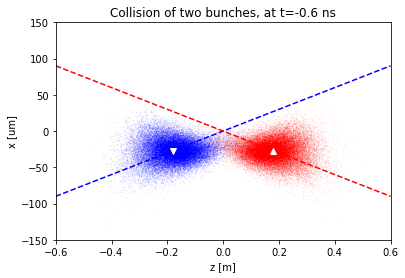

In [20]:
f(-.6)

### Python implementation

In [22]:
import numpy as np
from cl2pd import particle
from scipy import integrate

def beta(z, beta0, alpha_z0):
    '''Beta function in drift space'''
    return beta0-2*alpha_z0*z+(1+alpha_z0**2)/beta0*z**2
     
def dispersion(z, d0, dp0):
    '''Dispersion in drift space'''
    return d0+z*dp0
    
def sigma(beta, epsilon0, betagamma):
    '''Betatronic sigma'''
    return np.sqrt(beta*epsilon0/betagamma)

def L(f, nb, 
      N1, N2,
      x_1, x_2,
      y_1, y_2,
      px_1, px_2,
      py_1, py_2,
      energy_tot1, energy_tot2,
      deltap_p0_1, deltap_p0_2,
      epsilon_x1, epsilon_x2,
      epsilon_y1, epsilon_y2, 
      sigma_z1, sigma_z2,
      beta_x1, beta_x2,
      beta_y1, beta_y2,
      alpha_x1, alpha_x2,
      alpha_y1, alpha_y2,
      dx_1, dx_2,
      dy_1, dy_2,
      dpx_1, dpx_2,
      dpy_1, dpy_2,
      CC_V_x_1=0, CC_f_x_1=0, CC_phase_x_1=0,
      CC_V_x_2=0, CC_f_x_2=0, CC_phase_x_2=0,
      CC_V_y_1=0, CC_f_y_1=0, CC_phase_y_1=0,
      CC_V_y_2=0, CC_f_y_2=0, CC_phase_y_2=0,
      R12_1=0, R22_1=0, R34_1=0, R44_1=0,
      R12_2=0, R22_2=0, R34_2=0, R44_2=0,
      verbose=False, sigma_integration=3):
    '''
    Returns luminosity in Hz/cm^2.
    
    f: revolution frequency
    nb: number of colliding bunch per beam in the specific Interaction Point (IP).
    N1,2: B1,2 number of particle per bunch
    x,y,1,2: horizontal/vertical position at the IP of B1,2, as defined in MADX [m]
    px,y,1,2: px,py at the IP of B1,2, as defined in MADX
    energy_tot1,2: total energy of the B1,2 [GeV]
    deltap_p0_1,2: rms momentum spread of B1,2 (formulas assume Gaussian off-momentum distribution)
    epsilon_x,y,1,2: horizontal/vertical normalized emittances of B1,2 [m rad]
    sigma_z1,2: rms longitudinal spread in z of B1,2 [m]
    beta_x,y,1,2: horizontal/vertical beta-function at IP of B1,2 [m]
    alpha_x,y,1,2: horizontal/vertical alpha-function at IP of B1,2 
    dx,y_1,2: horizontal/vertical dispersion-function at IP of B1,2, as defined in MADX [m]
    dpx,y_1,2: horizontal/vertical differential-dispersion-function IP of B1,2, as defined in MADX 
    CC_V_x,y,1,2: B1,2 H/V CC total of the cavities that the beam sees before reaching the IP [V]
    CC_f_x,y,1,2: B1,2 H/V CC frequency of cavities that the beam sees before reaching the IP [Hz]
    CC_phase_1,2: B1,2 H/V CC phase of cavities that the beam sees before reaching the IP. 
        Sinusoidal function with respect to the center of the bunch is assumed.
        Therefore 0 rad means no kick for the central longitudinal slice [rad]
    RAB_1,2: B1,2 equivalent H/V linear transfer matrix coefficients between the CC
        that the beam sees before reaching the IP and IP itself [SI units] 
    verbose: to have verbose output
    sigma_integration: the number of sigma consider for the integration 
        (taken into account only if CC(s) is/are present)
    
    In MAD-X px is p_x/p_0 (p_x is the x-component of the momentum and p_0 is the design momentum).
    In our approximation we use the paraxial approximation: p_0~p_z so px is an angle. 
    Similar arguments holds for py.
    
    In MAD-X, dx and dpx are the literature dispersion and is derivative in s divided by the relatistic beta.
    In fact, since pt=beta*deltap, where beta is the relativistic Lorentz factor, 
    those functions given by MAD-X must be multiplied by beta a number of times equal to the order of
    the derivative to find the functions given in the literature.
    To note that dpx is normalized by the reference momentum (p_s) and not the design momentum (p_0),
    ps = p0(1+deltap). We assume that dpx is the z-derivative of the px.
    
    '''
    particle_1=particle.setTotalEnergy_GeV(energy_tot1)
    betagamma_1=particle_1['relativisticBetaGamma']
    br_1=particle_1['relativisticBeta']
    
    particle_2=particle.setTotalEnergy_GeV(energy_tot2)
    betagamma_2=particle_2['relativisticBetaGamma']
    br_2=particle_2['relativisticBeta']
    
    c=particle.speedOfLight_m_s
    
    # module of B1 speed
    v0_1=br_1*c 
    # paraxial hypothesis 
    vx_1=v0_1*px_1
    vy_1=v0_1*py_1
    vz_1=v0_1*np.sqrt(1-px_1**2-py_1**2)
    v_1=np.array([vx_1, vy_1, vz_1])
    
    v0_2=br_2*c # module of B2 speed
    # Assuming counter rotating B2 ('-' sign)
    vx_2=-v0_2*px_2
    vy_2=-v0_2*py_2
    # assuming px_2**2+py_2**2 < 1
    vz_2=-v0_2*np.sqrt(1-px_2**2-py_2**2)
    v_2=np.array([vx_2, vy_2, vz_2])
    
    if verbose:
        print(f'B1 velocity vector:{v_1}')
        print(f'B2 velocity vector:{v_2}')
        
    diff_v = v_1-v_2
    cross_v= np.cross(v_1, v_2)
    
    # normalized to get 1 for the ideal case 
    # NB we assume px_1 and py_1 constant along the z-slices 
    # NOT TRUE FOR CC! In any case the Moeller efficiency is almost equal to 1 in most cases...
    Moeller_efficiency=np.sqrt(c**2*np.dot(diff_v,diff_v)-np.dot(cross_v,cross_v))/c**2/2
    
    def sx1(z):
        '''The sigma_x of B1, quadratic sum of betatronic and dispersive sigma'''
        return np.sqrt(sigma(beta(z, beta_x1, alpha_x1), epsilon_x1, betagamma_1)**2 \
                       + (dispersion(z, br_1*dx_1, br_1*dpx_1)*deltap_p0_1)**2)
    
    def sy1(z):
        '''The sigma_y of B1, quadratic sum of betatronic and dispersive sigma'''
        return np.sqrt(sigma(beta(z, beta_y1, alpha_y1), epsilon_y1, betagamma_1)**2 \
                       + (dispersion(z, br_1*dy_1, br_1*dpy_1)*deltap_p0_1)**2)
    
    def sx2(z):
        '''The sigma_x of B2, quadratic sum of betatronic and dispersive sigma'''
        return np.sqrt(sigma(beta(z, beta_x2, alpha_x2), epsilon_x2, betagamma_2)**2 \
                       + (dispersion(z, br_2*dx_2, br_2*dpx_2)*deltap_p0_2)**2)
    
    def sy2(z):
        '''The sigma_y of B2, quadratic sum of betatronic and dispersive sigma'''
        return np.sqrt(sigma(beta(z, beta_y2, alpha_y2), epsilon_y2, betagamma_2)**2 \
                       + (dispersion(z, br_2*dy_2,  br_2*dpy_2)*deltap_p0_2)**2)
    
    sigma_z=np.max([sigma_z1, sigma_z2])
    
    if not [CC_V_x_1, CC_V_y_1, CC_V_x_2, CC_V_y_2]==[0,0,0,0]:
        q = particle.elementaryChargeProton_C
        def theta_x_1(delta_z):
            # Eq. 3 of https://espace.cern.ch/acc-tec-sector/Chamonix/Chamx2012/papers/RC_9_04.pdf
            return CC_V_x_1/energy_tot1/1e9*np.sin(CC_phase_x_1 + 2*np.pi*CC_f_x_1/c*delta_z)

        def theta_y_1(delta_z):
            return CC_V_y_1/energy_tot1/1e9*np.sin(CC_phase_y_1 + 2*np.pi*CC_f_y_1/c*delta_z)

        def theta_x_2(delta_z):
            return CC_V_x_2/energy_tot2/1e9*np.sin(CC_phase_x_2 + 2*np.pi*CC_f_x_2/c*delta_z)

        def theta_y_2(delta_z):
            return CC_V_y_2/energy_tot2/1e9*np.sin(CC_phase_y_2 + 2*np.pi*CC_f_y_2/c*delta_z)
        
        def mx1(z, t):
            '''The mu_x of B1 as straight line'''
            return x_1 + R12_1*theta_x_1(z-c*t) + (px_1+R22_1*theta_x_1(z-c*t))*z
    
        def my1(z, t):
            '''The mu_y of B1 as straight line'''
            return y_1 + R34_1*theta_y_1(z-c*t) + (py_1+R44_1*theta_y_1(z-c*t))*z

        def mx2(z, t):
            '''The mu_x of B2 as straight line'''
            return x_2 + R12_2*theta_x_2(z+c*t) + (px_2+R22_2*theta_x_2(z+c*t))*z

        def my2(z, t):
            '''The mu_y of B2 as straight line'''
            return y_2 + R34_2*theta_y_2(z+c*t) + (py_2+R44_2*theta_y_2(z+c*t))*z
        
        def kernel_double_integral(t, z):
            return np.exp(0.5*(-(mx1(z, t) - mx2(z, t))**2/(sx1(z)**2 + sx2(z)**2) \
                               -(my1(z, t) - my2(z, t))**2/(sy1(z)**2 + sy2(z)**2) \
                               -(-br_1*c*t+z)**2/(sigma_z1**2) \
                               -( br_2*c*t+z)**2/(sigma_z2**2))) \
        /np.sqrt((sx1(z)**2 + sx2(z)**2)*(sy1(z)**2 + sy2(z)**2))/sigma_z1/sigma_z2
        
        integral=integrate.dblquad((lambda t, z: kernel_double_integral(t, z)),
                                   -sigma_integration*sigma_z, sigma_integration*sigma_z,-sigma_integration*sigma_z/c, sigma_integration*sigma_z/c)
        L0=f*N1*N2*nb*c/2/np.pi**(2)*integral[0]
    else:
        def mx1(z):
            '''The mu_x of B1 as straight line'''
            return x_1 + px_1*z
    
        def my1(z):
            '''The mu_y of B1 as straight line'''
            return y_1 + py_1*z

        def mx2(z):
            '''The mu_x of B2 as straight line'''
            return x_2 + px_2*z

        def my2(z):
            '''The mu_y of B2 as straight line'''
            return y_2 + py_2*z
        
        def kernel_single_integral(z):
            return np.exp(0.5*(-(mx1(z) - mx2(z))**2/(sx1(z)**2 + sx2(z)**2) \
                               -(my1(z) - my2(z))**2/(sy1(z)**2 + sy2(z)**2) \
                               -((br_1+br_2)**2*z**2)/(br_2**2*sigma_z1**2 + br_1**2*sigma_z2**2))) \
            /np.sqrt((sx1(z)**2 + sx2(z)**2)*(sy1(z)**2 + sy2(z)**2)*(sigma_z1**2 + sigma_z2**2))
        
        integral=integrate.quad(lambda z: kernel_single_integral(z), -20*sigma_z, 20*sigma_z)
        L0=f*N1*N2*nb/np.sqrt(2)/np.pi**(3/2)*integral[0]
    result= L0*Moeller_efficiency/1e4
    if verbose:
        print(f'Moeller efficiency: {Moeller_efficiency}')
        print(f'Integral Relative Error: {integral[1]/integral[0]}')
        print(f'==> Luminosity [Hz/cm^2]: {result}')
    return result

In [23]:
%%time
L(f=11245, nb=2808,
    N1=1.15e11, N2=1.15e11,
    energy_tot1=7000, energy_tot2=7000,
    deltap_p0_1=0, deltap_p0_2=0,
    epsilon_x1=3.5e-6, epsilon_x2=3.5e-6,
    epsilon_y1=3.5e-6, epsilon_y2=3.5e-6, 
    sigma_z1=0.0755, sigma_z2=0.0755,
    beta_x1=0.55, beta_x2=0.55,
    beta_y1=0.55, beta_y2=0.55,
    alpha_x1=0, alpha_x2=0,
    alpha_y1=0, alpha_y2=0,
    dx_1=0, dx_2=0,
    dpx_1=0, dpx_2=0,
    dy_1=0, dy_2=0,
    dpy_1=0, dpy_2=0,
    x_1=0, x_2=0,
    px_1=285e-6/2, px_2=-285e-6/2,
    y_1=0, y_2=0,
    py_1=0, py_2=0, verbose=True)

B1 velocity vector:[4.27204249e+04 0.00000000e+00 2.99792452e+08]
B2 velocity vector:[ 4.27204249e+04 -0.00000000e+00 -2.99792452e+08]
Moeller efficiency: 0.9999999707105369
Integral Relative Error: 6.316252801470438e-11
==> Luminosity [Hz/cm^2]: 1.066312475289246e+34
CPU times: user 38.3 ms, sys: 4.01 ms, total: 42.3 ms
Wall time: 38.3 ms


1.066312475289246e+34

In [39]:
def L_simple(sigma_integration) : 
    return L(f=11245, nb=2808,
    N1=1.15e11, N2=1.15e11,
    energy_tot1=7000, energy_tot2=7000,
    deltap_p0_1=1e-4, deltap_p0_2=0,
    epsilon_x1=3.5e-6, epsilon_x2=3.5e-6,
    epsilon_y1=3.5e-6, epsilon_y2=3.5e-6, 
    sigma_z1=0.0755, sigma_z2=0.0755,
    beta_x1=0.55, beta_x2=0.55,
    beta_y1=0.55, beta_y2=0.55,
    alpha_x1=0, alpha_x2=0,
    alpha_y1=0, alpha_y2=0,
    dx_1=0, dx_2=0,
    dpx_1=0, dpx_2=0,
    dy_1=0, dy_2=0,
    dpy_1=0, dpy_2=0,
    x_1=0, x_2=0,
    px_1=0, px_2=0,
    y_1=0, y_2=0,
    py_1=285e-6/2, py_2=-285e-6/2, CC_V_y_1=-6.8e6, R34_1=20, CC_f_y_1=400e6,
    CC_V_y_2=6.8e6, R34_2=20, CC_f_y_2=400e6, verbose=False,sigma_integration=sigma_integration)

print('Performance with 3-sigma z-t integration')
%timeit L_simple(3)
print(L_simple(3))

print('===============')
print('Performance with 5-sigma z-t integration')
%timeit L_simple(5)
print(L_simple(5))

Performance with 3-sigma z-t integration
307 ms ± 21.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.2692125879650769e+34
Performance with 5-sigma z-t integration
1.25 s ± 5.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.2692417302271363e+34


!!! warning
    For the leveling one should find the trade-off between precision and speed.


### Levelling luminosity 

Here the pythonic approach is paying off: we can use the standard tools to invert numerically the luminosity formula. We will concentrate on the least_square method but there are many we could consider (e.g., the fsolve).

!!! warning
    The numeric values considered in the following are **arbitrary**.

#### Intensity leveling
Clearly the intensity leveling can be done in a simpler way (the bunch intensity is not in the kernel of the integral). Here we report it for the sake of the example.


In [74]:
print('\n==== Intensity Levelling ====')

from scipy.optimize import least_squares
#from scipy.optimize import fsolve

L_target=1e+34
starting_guess=1.15e11

def function_to_minimize(N):
    return L(f=11245, nb=2808,
    N1=N, N2=N,
    energy_tot1=7000, energy_tot2=7000,
    deltap_p0_1=1e-4, deltap_p0_2=0,
    epsilon_x1=3.5e-6, epsilon_x2=3.5e-6,
    epsilon_y1=3.5e-6, epsilon_y2=3.5e-6, 
    sigma_z1=0.0755, sigma_z2=0.0755,
    beta_x1=0.55, beta_x2=0.55,
    beta_y1=0.55, beta_y2=0.55,
    alpha_x1=0, alpha_x2=0,
    alpha_y1=0, alpha_y2=0,
    dx_1=0, dx_2=0,
    dpx_1=0, dpx_2=0,
    dy_1=0, dy_2=0,
    dpy_1=0, dpy_2=0,
    x_1=0, x_2=0,
    px_1=0, px_2=0,
    y_1=0, y_2=0,
    py_1=285e-6/2, py_2=-285e-6/2, verbose=False)-L_target

aux=least_squares(function_to_minimize, starting_guess)
print(aux)
print(f"\nLuminosity after levelling: {function_to_minimize(aux['x'][0])+L_target} Hz/cm^2")


==== Intensity Levelling ====
 active_mask: array([0.])
        cost: 0.0
         fun: array([0.])
        grad: array([0.])
         jac: array([[1.79586794e+23]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 5
        njev: 5
  optimality: 0.0
      status: 1
     success: True
           x: array([1.11366763e+11])

Luminosity after levelling: 1e+34 Hz/cm^2


#### Crossing Angle Levelling

It is possible to  define boundary constrains for the parameter used for the optimization.

In [76]:
print('\n==== Crossing Angle Levelling ====')

L_target=1e+34
starting_guess=100e-6

def function_to_minimize(N):
    return L(f=11245, nb=2808,
    N1=1.1e11, N2=1.1e11,
    energy_tot1=7000, energy_tot2=7000,
    deltap_p0_1=1e-4, deltap_p0_2=0,
    epsilon_x1=3.5e-6, epsilon_x2=3.5e-6,
    epsilon_y1=3.5e-6, epsilon_y2=3.5e-6, 
    sigma_z1=0.0755, sigma_z2=0.0755,
    beta_x1=0.55, beta_x2=0.55,
    beta_y1=0.55, beta_y2=0.55,
    alpha_x1=0, alpha_x2=0,
    alpha_y1=0, alpha_y2=0,
    dx_1=0, dx_2=0,
    dpx_1=0, dpx_2=0,
    dy_1=0, dy_2=0,
    dpy_1=0, dpy_2=0,
    x_1=0, x_2=0,
    px_1=0, px_2=0, 
    y_1=0, y_2=0, 
    # NB the N[0]. It is not clear to me why, but is needed 
    py_1=N[0], py_2=-N[0], verbose=False)-L_target
    
aux=least_squares(function_to_minimize, starting_guess, bounds=(90e-6, 150e-6))
print(aux)
print(f"\nLuminosity after levelling: {function_to_minimize(aux['x'])+L_target} Hz/cm^2")


==== Crossing Angle Levelling ====
 active_mask: array([0])
        cost: 6.64613997892458e+35
         fun: array([-1.1529215e+18])
        grad: array([2.36230951e+55])
         jac: array([[-2.04897688e+37]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 8
        njev: 8
  optimality: 9.611370998526366e+50
      status: 3
     success: True
           x: array([0.00013069])

Luminosity after levelling: 9.999999999999998e+33 Hz/cm^2


#### Beta-function levelling

In [89]:
print('\n==== Beta-function Levelling ====')

L_target=1.1e+34
starting_guess=.55

def function_to_minimize(beta):
    return L(f=11245, nb=2808,
    N1=1.1e11, N2=1.1e11,
    energy_tot1=7000, energy_tot2=7000,
    deltap_p0_1=1e-4, deltap_p0_2=0,
    epsilon_x1=3.5e-6, epsilon_x2=3.5e-6,
    epsilon_y1=3.5e-6, epsilon_y2=3.5e-6, 
    sigma_z1=0.0755, sigma_z2=0.0755,
    beta_x1=beta, beta_x2=beta,
    beta_y1=beta, beta_y2=beta,
    alpha_x1=0, alpha_x2=0,
    alpha_y1=0, alpha_y2=0,
    dx_1=0, dx_2=0,
    dpx_1=0, dpx_2=0,
    dy_1=0, dy_2=0,
    dpy_1=0, dpy_2=0,
    x_1=0, x_2=0,
    px_1=0, px_2=0, 
    y_1=0, y_2=0, 
    py_1=150e-6, py_2=-150e-6, verbose=False)-L_target
    
aux=least_squares(function_to_minimize, starting_guess, bounds=(.15, .6))
print(aux)
print(f"\nLuminosity after levelling: {function_to_minimize(aux['x'])+L_target} Hz/cm^2")


==== Beta-function Levelling ====
 active_mask: array([0])
        cost: 2.658455991569832e+36
         fun: array([2.30584301e+18])
        grad: array([-4.41852739e+52])
         jac: array([[-1.9162308e+34]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 5
        njev: 5
  optimality: 5.9215451810614056e+51
      status: 3
     success: True
           x: array([0.46598374])

Luminosity after levelling: 1.1000000000000003e+34 Hz/cm^2


#### Offset Levelling

In [77]:
print('\n==== Offset Levelling ====')
L_target=1e+34
starting_guess=5e-6

def function_to_minimize(N):
    return L(f=11245, nb=2808,
    N1=1.3e11, N2=1.3e11,
    energy_tot1=7000, energy_tot2=7000,
    deltap_p0_1=1e-4, deltap_p0_2=0,
    epsilon_x1=3.5e-6, epsilon_x2=3.5e-6,
    epsilon_y1=3.5e-6, epsilon_y2=3.5e-6, 
    sigma_z1=0.0755, sigma_z2=0.0755,
    beta_x1=0.55, beta_x2=0.55,
    beta_y1=0.55, beta_y2=0.55,
    alpha_x1=0, alpha_x2=0,
    alpha_y1=0, alpha_y2=0,
    dx_1=0, dx_2=0,
    dpx_1=0, dpx_2=0,
    dy_1=0, dy_2=0,
    dpy_1=0, dpy_2=0,
    x_1=N, x_2=-N,
    px_1=0, px_2=0, 
    y_1=0, y_2=0, 
    py_1=285e-6/2, py_2=-285e-6/2, verbose=False)-L_target
    
aux=least_squares(function_to_minimize, starting_guess, bounds=(0, 1e-5))
print(aux)
print(f"\nLuminosity after levelling: {function_to_minimize(aux['x'][0])+L_target} Hz/cm^2")


==== Offset Levelling ====
 active_mask: array([0])
        cost: 8.389105142212503e+43
         fun: array([1.29530731e+22])
        grad: array([-8.94500889e+60])
         jac: array([[-6.90570401e+38]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 8
        njev: 8
  optimality: 9.269268504796618e+54
      status: 3
     success: True
           x: array([8.96374966e-06])

Luminosity after levelling: 1.0000000000012953e+34 Hz/cm^2


#### CC voltage Levelling

Clearly we are now very flexible on the leveling strategy, we can also level with the CC voltage.

In [82]:
%%time

L_target=1.1e+34
starting_guess=.5

print('\n==== Crab Crossing Levelling ====')

def function_to_minimize(V0):
    return L(f=11245, nb=2808,
    N1=1.15e11, N2=1.15e11,
    energy_tot1=7000, energy_tot2=7000,
    deltap_p0_1=1e-4, deltap_p0_2=0,
    epsilon_x1=3.5e-6, epsilon_x2=3.5e-6,
    epsilon_y1=3.5e-6, epsilon_y2=3.5e-6, 
    sigma_z1=0.0755, sigma_z2=0.0755,
    beta_x1=0.55, beta_x2=0.55,
    beta_y1=0.55, beta_y2=0.55,
    alpha_x1=0, alpha_x2=0,
    alpha_y1=0, alpha_y2=0,
    dx_1=0, dx_2=0,
    dpx_1=0, dpx_2=0,
    dy_1=0, dy_2=0,
    dpy_1=0, dpy_2=0,
    x_1=0, x_2=0,
    px_1=0, px_2=0,
    y_1=0, y_2=0,
    py_1=285e-6/2, py_2=-285e-6/2, CC_V_y_1=V0*-6.8e6, R34_1=20, CC_f_y_1=400e6,
    CC_V_y_2=V0*6.8e6, R34_2=20, CC_f_y_2=400e6, verbose=False,sigma_integration=3)-L_target

aux=least_squares(function_to_minimize, starting_guess, bounds=(0, 1))
print(aux)
print(f"\nLuminosity after levelling: {function_to_minimize(aux['x'][0])+L_target} Hz/cm^2")


==== Crab Crossing Levelling ====
 active_mask: array([0])
        cost: 0.0
         fun: array([0.])
        grad: array([0.])
         jac: array([[3.03604083e+33]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 8
        njev: 8
  optimality: 0.0
      status: 1
     success: True
           x: array([0.10930041])

Luminosity after levelling: 1.1e+34 Hz/cm^2
CPU times: user 6.9 s, sys: 4.65 ms, total: 6.9 s
Wall time: 6.89 s


#### Leveling on two-variables
One can do the dummy leveling of two variables.

In [128]:
print('\n==== Beta and crossing Levelling ====')

L_target=1.1e+34
starting_beta=.55
starting_angle=150e-6
def function_to_minimize(x):
    return L(f=11245, nb=2808,
    N1=1.1e11, N2=1.1e11,
    energy_tot1=7000, energy_tot2=7000,
    deltap_p0_1=1e-4, deltap_p0_2=0,
    epsilon_x1=3.5e-6, epsilon_x2=3.5e-6,
    epsilon_y1=3.5e-6, epsilon_y2=3.5e-6, 
    sigma_z1=0.0755, sigma_z2=0.0755,
    beta_x1=x[0], beta_x2=x[0],
    beta_y1=x[0], beta_y2=x[0],
    alpha_x1=0, alpha_x2=0,
    alpha_y1=0, alpha_y2=0,
    dx_1=0, dx_2=0,
    dpx_1=0, dpx_2=0,
    dy_1=0, dy_2=0,
    dpy_1=0, dpy_2=0,
    x_1=0, x_2=0,
    px_1=0, px_2=0, 
    y_1=0, y_2=0, 
    py_1=x[1], py_2=-x[1], verbose=False)-L_target

function_to_minimize([starting_beta, starting_angle])
aux=least_squares(function_to_minimize, (starting_beta, starting_angle),bounds=((0.15,90e-6),(.60, 150e-6)))
print(aux)
print(f"\nLuminosity after levelling: {function_to_minimize(aux['x'])+L_target} Hz/cm^2")


==== Beta and crossing Levelling ====
 active_mask: array([0, 0])
        cost: 6.646139978924579e+39
         fun: array([-1.1529215e+20])
        grad: array([2.18131014e+54, 2.79401123e+57])
         jac: array([[-1.89198495e+34, -2.42341844e+37]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 6
        njev: 6
  optimality: 7.475750819526882e+53
      status: 3
     success: True
           x: array([4.92718382e-01, 1.29970419e-04])

Luminosity after levelling: 1.0999999999999886e+34 Hz/cm^2


Or we can do beta-leveling a constant BB normalized separation.

In [143]:
print('\n==== Beta and crossing Levelling ====')

L_target=1.1e+34
starting_beta=.55
def function_to_minimize(beta):
    return L(f=11245, nb=2808,
    N1=1.1e11, N2=1.1e11,
    energy_tot1=7000, energy_tot2=7000,
    deltap_p0_1=1e-4, deltap_p0_2=0,
    epsilon_x1=3.5e-6, epsilon_x2=3.5e-6,
    epsilon_y1=3.5e-6, epsilon_y2=3.5e-6, 
    sigma_z1=0.0755, sigma_z2=0.0755,
    beta_x1=beta, beta_x2=beta,
    beta_y1=beta, beta_y2=beta,
    alpha_x1=0, alpha_x2=0,
    alpha_y1=0, alpha_y2=0,
    dx_1=0, dx_2=0,
    dpx_1=0, dpx_2=0,
    dy_1=0, dy_2=0,
    dpy_1=0, dpy_2=0,
    x_1=0, x_2=0,
    px_1=0, px_2=0, 
    y_1=0, y_2=0, 
    py_1=120e-6*np.sqrt(.6/beta[0]), py_2=-120e-6*np.sqrt(.6/beta[0]), verbose=False)-L_target

aux=least_squares(function_to_minimize, starting_beta, bounds=(0.15,.60))
print(aux)

print(f'\nCrossing angle of {140*np.sqrt(.6/aux["x"][0]): 2.2f} murad')
print(f"\nLuminosity after levelling: {function_to_minimize(aux['x'])+L_target} Hz/cm^2")


==== Beta and crossing Levelling ====
 active_mask: array([0])
        cost: 2.658455991569832e+36
         fun: array([2.30584301e+18])
        grad: array([-3.5984086e+52])
         jac: array([[-1.56056097e+34]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 5
        njev: 5
  optimality: 3.998167214242363e+51
      status: 3
     success: True
           x: array([0.48889068])

Crossing angle of  155.09 murad

Luminosity after levelling: 1.1000000000000003e+34 Hz/cm^2


!!! success
    We show the flexibility of the luminosity levelling in python. Keep in mind the HP1 (i.e., no x-y tilted distributions) and HP3 (i.e., normal distribution).

### M-Gaussian distributions

As shown in [S. Papadopoulou et al., 2020](https://arxiv.org/pdf/1806.07317.pdf) for LHC, in general the assumptions for Gaussian beam distributions do not hold.


An simple generalization of the proposed python approach presented in this notebook, is to express the distribution as the sum of M-Gaussian distributions (same $\mu$ but different $\sigma$), that is,  

\begin{equation}
\rho_{x}^{B1}=\sum_{i=1}^M c_{x,i}^{B1} N(x,\mu_x^{B1}, \sigma_{x,i}^{B1})=\sum_{i=1}^M c_{x,i}^{B1} N_{x,i}^{B1}
\end{equation}

with the normalization condition 

\begin{equation}
\sum_{i=1}^M c_{x,i}^{B1}=1.
\end{equation}

Similar expressions can be considered for the other planes and beam.

If we consider only the transverse plane we have
\begin{equation}
\rho_x^{B1} \rho_y^{B1} \rho_x^{B2} \rho_y^{B2}=
\sum_{i=1}^{M} \sum_{j=1}^{M} \sum_{k=1}^{M} \sum_{l=1}^{M} c_{x,i}^{B1} c_{y,j}^{B1} c_{x,k}^{B2} c_{y,l}^{B2}\ N_{x,i}^{B1} N_{y,j}^{B1} N_{x,k}^{B2} N_{y,l}^{B2}/
\end{equation}

Therefore, by denoting with

\begin{equation}
L_{i,j,k,l}=N_1 N_2 n_b f_r \underbrace{\sqrt{(\vec{v_1}-\vec{v_2})^2-\frac{(\vec{v_1} \times \vec{v_2})^2}{c^2}}}_{Moeller~factor}
\int_{-\infty}^{\infty}
\int_{-\infty}^{\infty}
\rho_z^{B1} \rho_z^{B2}~ 
\underbrace{\int_{-\infty}^{\infty}\int_{-\infty}^{\infty} N_{x,i}^{B1} N_{y,j}^{B1} N_{x,k}^{B2} N_{y,l}^{B2} dx dy}_{analytically~integrated} ~
dz dt,
\end{equation}

(we have **already** a python function for $L_{i,j,k,l}$), the luminosity can be expressed as 

\begin{equation}
L=\sum_{i=1}^{M} \sum_{j=1}^{M} \sum_{k=1}^{M} \sum_{l=1}^{M} c_{x,i}^{B1} c_{y,j}^{B1} c_{x,k}^{B2} c_{y,l}^{B2}\ L_{i,j,k,l}.
\end{equation}


#### Sanity check
We can make a simple sanity check by considering 3-Gaussian with the same sigmas.
In the luminosity function we have we decide not to impose beam sigmas, so we impose emittances (this is a detail of the implementation).

In [185]:
# Amplitude coefficient of the 3-Gaussian
c_b1_x=[.8, .1, .1]
c_b1_y=[.7, .2, .1]
c_b2_x=[.85, .10, .05]
c_b2_y=[.9, .1, 0]


# Emittance (then related to the sigma-cofficient of the 2-Gaussian)
e_b1_x=[3.5e-6, 3.5e-6, 3.5e-6]
e_b1_y=e_b1_x
e_b2_x=e_b1_x
e_b2_y=e_b1_x


# To make the notation compact, 
# we reduce the luminosity function as depending on the emittances only.
def simpleL(epsilon_x1, epsilon_y1, epsilon_x2, epsilon_y2):
    return L(f=11245, nb=2808,
    N1=1.1e11, N2=1.1e11,
    energy_tot1=7000, energy_tot2=7000,
    deltap_p0_1=1e-4, deltap_p0_2=0,
    epsilon_x1=epsilon_x1, epsilon_x2=epsilon_x2,
    epsilon_y1=epsilon_y1, epsilon_y2=epsilon_y2, 
    sigma_z1=0.0755, sigma_z2=0.0755,
    beta_x1=.4, beta_x2=.4,
    beta_y1=.4, beta_y2=.4,
    alpha_x1=0, alpha_x2=0,
    alpha_y1=0, alpha_y2=0,
    dx_1=0, dx_2=0,
    dpx_1=0, dpx_2=0,
    dy_1=0, dy_2=0,
    dpy_1=0, dpy_2=0,
    x_1=0, x_2=0,
    px_1=0, px_2=0, 
    y_1=0, y_2=0, 
    py_1=150e-6, py_2=150e-6, verbose=False)


# this is just a product between sums is the sums of product
aux=[]
for cb1_x, eb1_x  in zip(c_b1_x, e_b1_x):
    for cb1_y, eb1_y in zip(c_b1_y, e_b1_y):
        for cb2_x, eb2_x in zip(c_b2_x, e_b2_x):
            for cb2_y, eb2_y in zip(c_b2_y, e_b2_y):
                aux.append(cb1_x*cb1_y*cb2_x*cb2_y*simpleL(eb1_x, eb1_y, eb2_x, eb2_y))
                
                
print(f'The expected luminosity is {simpleL(3.5e-6, 3.5e-6, 3.5e-6, 3.5e-6)} Hz/cm^2')
print(f'The computed luminosity is {np.sum(aux)} Hz/cm^2')

The expected luminosity is 1.592775350199377e+34 Hz/cm^2
The computed luminosity is 1.5927753501993768e+34 Hz/cm^2


!!! Success
    Indeed we sanity check is positive.
    
If we do a "real" test we obtain the, e.g., the following

In [190]:
# Amplitude coefficient of the 3-Gaussian
c_b1_x=[.8, .1, .1]
c_b1_y=[.7, .2, .1]
c_b2_x=[.85, .10, .05]
c_b2_y=[.9, .1, 0]


# Emittance (then related to the sigma-cofficient of the 2-Gaussian)
e_b1_x=[3.5e-6, 5.5e-6, 8e-6]
e_b1_y=[3.5e-6, 6.5e-6, 8.5e-6]
e_b2_x=[3.5e-6, 5.5e-6, 8.2e-6]
e_b2_y=[3.5e-6, 9.5e-6, 8e-6]

# this is just a product between sums is the sums of product
aux=[]
for cb1_x, eb1_x  in zip(c_b1_x, e_b1_x):
    for cb1_y, eb1_y in zip(c_b1_y, e_b1_y):
        for cb2_x, eb2_x in zip(c_b2_x, e_b2_x):
            for cb2_y, eb2_y in zip(c_b2_y, e_b2_y):
                aux.append(cb1_x*cb1_y*cb2_x*cb2_y*simpleL(eb1_x, eb1_y, eb2_x, eb2_y))
                
print(f'The computed luminosity is {np.sum(aux)} Hz/cm^2')

The computed luminosity is 1.3847350390702277e+34 Hz/cm^2


As it should be, the luminosity is lower than in the previous test.